In [1]:
# install: tqdm (progress bars)
!pip install tqdm
!pip install torchvision

import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


## Load the data (CIFAR-10)

In [2]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()
train_dl = make_loader(TensorDataset(X_tr, Y_tr))
test_dl = make_loader(TensorDataset(X_te, Y_te))

Files already downloaded and verified
Files already downloaded and verified


## Training helper functions

In [3]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50, printer = True):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    iterator = tqdm(train_dl) if printer else train_dl
    for i, (xB, yB) in enumerate(iterator):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

In [4]:
## Define model

In [4]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [5]:
## Train

In [5]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 5.476 	 Train Acc: 0.166
	 [Batch 100 / 391] Train Loss: 3.826 	 Train Acc: 0.190
	 [Batch 150 / 391] Train Loss: 3.230 	 Train Acc: 0.213
	 [Batch 200 / 391] Train Loss: 2.906 	 Train Acc: 0.231
	 [Batch 250 / 391] Train Loss: 2.691 	 Train Acc: 0.250
	 [Batch 300 / 391] Train Loss: 2.539 	 Train Acc: 0.265
	 [Batch 350 / 391] Train Loss: 2.418 	 Train Acc: 0.281
Epoch 0:	 Train Loss: 2.338 	 Train Acc: 0.293	 Test Acc: 0.351
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.564 	 Train Acc: 0.423
	 [Batch 100 / 391] Train Loss: 1.533 	 Train Acc: 0.439
	 [Batch 150 / 391] Train Loss: 1.514 	 Train Acc: 0.448
	 [Batch 200 / 391] Train Loss: 1.491 	 Train Acc: 0.457
	 [Batch 250 / 391] Train Loss: 1.467 	 Train Acc: 0.466
	 [Batch 300 / 391] Train Loss: 1.438 	 Train Acc: 0.477
	 [Batch 350 / 391] Train Loss: 1.410 	 Train Acc: 0.488
Epoch 1:	 Train Loss: 1.391 	 Train Acc: 0.495	 Test Acc: 0.495
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.171 	 Train Acc: 0.578
	 [Batch 100 / 391] Train Loss: 1.164 	 Train Acc: 0.580
	 [Batch 150 / 391] Train Loss: 1.143 	 Train Acc: 0.588
	 [Batch 200 / 391] Train Loss: 1.137 	 Train Acc: 0.592
	 [Batch 250 / 391] Train Loss: 1.128 	 Train Acc: 0.595
	 [Batch 300 / 391] Train Loss: 1.110 	 Train Acc: 0.602
	 [Batch 350 / 391] Train Loss: 1.103 	 Train Acc: 0.606
Epoch 2:	 Train Loss: 1.089 	 Train Acc: 0.611	 Test Acc: 0.513
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.930 	 Train Acc: 0.679
	 [Batch 100 / 391] Train Loss: 0.928 	 Train Acc: 0.677
	 [Batch 150 / 391] Train Loss: 0.921 	 Train Acc: 0.677
	 [Batch 200 / 391] Train Loss: 0.908 	 Train Acc: 0.681
	 [Batch 250 / 391] Train Loss: 0.903 	 Train Acc: 0.683
	 [Batch 300 / 391] Train Loss: 0.897 	 Train Acc: 0.684
	 [Batch 350 / 391] Train Loss: 0.893 	 Train Acc: 0.686
Epoch 3:	 Train Loss: 0.888 	 Train Acc: 0.689	 Test Acc: 0.644
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.781 	 Train Acc: 0.729
	 [Batch 100 / 391] Train Loss: 0.768 	 Train Acc: 0.734
	 [Batch 150 / 391] Train Loss: 0.774 	 Train Acc: 0.731
	 [Batch 200 / 391] Train Loss: 0.773 	 Train Acc: 0.730
	 [Batch 250 / 391] Train Loss: 0.778 	 Train Acc: 0.729
	 [Batch 300 / 391] Train Loss: 0.772 	 Train Acc: 0.731
	 [Batch 350 / 391] Train Loss: 0.767 	 Train Acc: 0.732
Epoch 4:	 Train Loss: 0.766 	 Train Acc: 0.733	 Test Acc: 0.726
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.696 	 Train Acc: 0.748
	 [Batch 100 / 391] Train Loss: 0.680 	 Train Acc: 0.757
	 [Batch 150 / 391] Train Loss: 0.680 	 Train Acc: 0.761
	 [Batch 200 / 391] Train Loss: 0.669 	 Train Acc: 0.766
	 [Batch 250 / 391] Train Loss: 0.665 	 Train Acc: 0.768
	 [Batch 300 / 391] Train Loss: 0.662 	 Train Acc: 0.770
	 [Batch 350 / 391] Train Loss: 0.661 	 Train Acc: 0.770
Epoch 5:	 Train Loss: 0.658 	 Train Acc: 0.770	 Test Acc: 0.731
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.581 	 Train Acc: 0.798
	 [Batch 100 / 391] Train Loss: 0.572 	 Train Acc: 0.803
	 [Batch 150 / 391] Train Loss: 0.574 	 Train Acc: 0.801
	 [Batch 200 / 391] Train Loss: 0.590 	 Train Acc: 0.798
	 [Batch 250 / 391] Train Loss: 0.584 	 Train Acc: 0.799
	 [Batch 300 / 391] Train Loss: 0.587 	 Train Acc: 0.798
	 [Batch 350 / 391] Train Loss: 0.586 	 Train Acc: 0.799
Epoch 6:	 Train Loss: 0.586 	 Train Acc: 0.799	 Test Acc: 0.713
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.473 	 Train Acc: 0.835
	 [Batch 100 / 391] Train Loss: 0.469 	 Train Acc: 0.836
	 [Batch 150 / 391] Train Loss: 0.484 	 Train Acc: 0.831
	 [Batch 200 / 391] Train Loss: 0.487 	 Train Acc: 0.831
	 [Batch 250 / 391] Train Loss: 0.488 	 Train Acc: 0.830
	 [Batch 300 / 391] Train Loss: 0.489 	 Train Acc: 0.830
	 [Batch 350 / 391] Train Loss: 0.494 	 Train Acc: 0.828
Epoch 7:	 Train Loss: 0.494 	 Train Acc: 0.829	 Test Acc: 0.753
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.434 	 Train Acc: 0.853
	 [Batch 100 / 391] Train Loss: 0.431 	 Train Acc: 0.854
	 [Batch 150 / 391] Train Loss: 0.418 	 Train Acc: 0.858
	 [Batch 200 / 391] Train Loss: 0.431 	 Train Acc: 0.853
	 [Batch 250 / 391] Train Loss: 0.437 	 Train Acc: 0.851
	 [Batch 300 / 391] Train Loss: 0.435 	 Train Acc: 0.852
	 [Batch 350 / 391] Train Loss: 0.439 	 Train Acc: 0.850
Epoch 8:	 Train Loss: 0.437 	 Train Acc: 0.851	 Test Acc: 0.710
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.355 	 Train Acc: 0.884
	 [Batch 100 / 391] Train Loss: 0.367 	 Train Acc: 0.881
	 [Batch 150 / 391] Train Loss: 0.375 	 Train Acc: 0.876
	 [Batch 200 / 391] Train Loss: 0.372 	 Train Acc: 0.876
	 [Batch 250 / 391] Train Loss: 0.380 	 Train Acc: 0.874
	 [Batch 300 / 391] Train Loss: 0.376 	 Train Acc: 0.874
	 [Batch 350 / 391] Train Loss: 0.383 	 Train Acc: 0.873
Epoch 9:	 Train Loss: 0.383 	 Train Acc: 0.872	 Test Acc: 0.711
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.289 	 Train Acc: 0.899
	 [Batch 100 / 391] Train Loss: 0.286 	 Train Acc: 0.901
	 [Batch 150 / 391] Train Loss: 0.306 	 Train Acc: 0.897
	 [Batch 200 / 391] Train Loss: 0.301 	 Train Acc: 0.898
	 [Batch 250 / 391] Train Loss: 0.306 	 Train Acc: 0.896
	 [Batch 300 / 391] Train Loss: 0.306 	 Train Acc: 0.895
	 [Batch 350 / 391] Train Loss: 0.313 	 Train Acc: 0.893
Epoch 10:	 Train Loss: 0.314 	 Train Acc: 0.893	 Test Acc: 0.712
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.213 	 Train Acc: 0.927
	 [Batch 100 / 391] Train Loss: 0.232 	 Train Acc: 0.923
	 [Batch 150 / 391] Train Loss: 0.255 	 Train Acc: 0.918
	 [Batch 200 / 391] Train Loss: 0.258 	 Train Acc: 0.917
	 [Batch 250 / 391] Train Loss: 0.264 	 Train Acc: 0.914
	 [Batch 300 / 391] Train Loss: 0.274 	 Train Acc: 0.912
	 [Batch 350 / 391] Train Loss: 0.275 	 Train Acc: 0.911
Epoch 11:	 Train Loss: 0.278 	 Train Acc: 0.908	 Test Acc: 0.755
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.141 	 Train Acc: 0.954
	 [Batch 100 / 391] Train Loss: 0.163 	 Train Acc: 0.951
	 [Batch 150 / 391] Train Loss: 0.160 	 Train Acc: 0.951
	 [Batch 200 / 391] Train Loss: 0.163 	 Train Acc: 0.949
	 [Batch 250 / 391] Train Loss: 0.177 	 Train Acc: 0.943
	 [Batch 300 / 391] Train Loss: 0.178 	 Train Acc: 0.942
	 [Batch 350 / 391] Train Loss: 0.193 	 Train Acc: 0.939
Epoch 12:	 Train Loss: 0.197 	 Train Acc: 0.937	 Test Acc: 0.803
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.103 	 Train Acc: 0.970
	 [Batch 100 / 391] Train Loss: 0.101 	 Train Acc: 0.970
	 [Batch 150 / 391] Train Loss: 0.122 	 Train Acc: 0.966
	 [Batch 200 / 391] Train Loss: 0.130 	 Train Acc: 0.962
	 [Batch 250 / 391] Train Loss: 0.143 	 Train Acc: 0.958
	 [Batch 300 / 391] Train Loss: 0.144 	 Train Acc: 0.956
	 [Batch 350 / 391] Train Loss: 0.156 	 Train Acc: 0.953
Epoch 13:	 Train Loss: 0.164 	 Train Acc: 0.951	 Test Acc: 0.814
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.059 	 Train Acc: 0.983
	 [Batch 100 / 391] Train Loss: 0.052 	 Train Acc: 0.985
	 [Batch 150 / 391] Train Loss: 0.052 	 Train Acc: 0.986
	 [Batch 200 / 391] Train Loss: 0.051 	 Train Acc: 0.986
	 [Batch 250 / 391] Train Loss: 0.103 	 Train Acc: 0.975
	 [Batch 300 / 391] Train Loss: 0.099 	 Train Acc: 0.975
	 [Batch 350 / 391] Train Loss: 0.098 	 Train Acc: 0.974
Epoch 14:	 Train Loss: 0.098 	 Train Acc: 0.973	 Test Acc: 0.813
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.031 	 Train Acc: 0.994
	 [Batch 100 / 391] Train Loss: 0.028 	 Train Acc: 0.995
	 [Batch 150 / 391] Train Loss: 0.026 	 Train Acc: 0.995
	 [Batch 200 / 391] Train Loss: 0.026 	 Train Acc: 0.995
	 [Batch 250 / 391] Train Loss: 0.027 	 Train Acc: 0.995
	 [Batch 300 / 391] Train Loss: 0.026 	 Train Acc: 0.995
	 [Batch 350 / 391] Train Loss: 0.026 	 Train Acc: 0.995
Epoch 15:	 Train Loss: 0.026 	 Train Acc: 0.995	 Test Acc: 0.850
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.009 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.009 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.009 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.008 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.008 	 Train Acc: 1.000	 Test Acc: 0.854
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.004 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.004 	 Train Acc: 1.000	 Test Acc: 0.859
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.860
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.859


## Flipping an Image

7


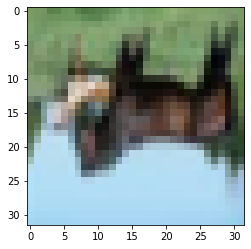

In [6]:
idx = 12
img = torch.flip(train_dl.dataset.tensors[0][idx], [1])
plt.imshow(np.transpose(np.array(img), (1, 2, 0)))
print(np.array(train_dl.dataset.tensors[1][idx]))

def plot_image(img):
    plt.imshow(np.transpose(np.array(img), (1, 2, 0)))
    plt.show()

In [7]:
# Flipping images in test set
X_te_flipped = torch.flip(X_te, [2])

test_dl_flipped = make_loader(TensorDataset(X_te_flipped, Y_te))

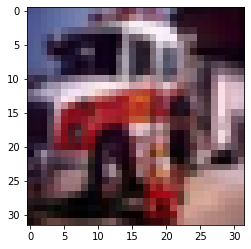

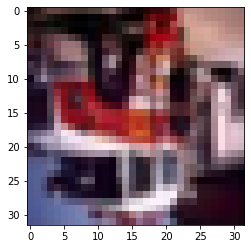

tensor(9)


In [8]:
idx=1231
plot_image(X_te[idx])
plot_image(X_te_flipped[idx])
print(Y_te[idx])

In [9]:
test_loss, test_acc = evaluate(model, test_dl_flipped)

In [10]:
print(test_loss, test_acc)

3.04576484375 0.4293


In [ ]:
# Organize the test data by class
classes = {}
for i in range(10):
    classes[i] = []

for idx, y in enumerate(Y_te):
    classes[int(y)].append(idx)

# print('')
    
for label in classes:
    idxs = np.array(classes[label])
    X_temp = X_te[idxs]
    X_temp_flipped = X_te_flipped[idxs]
    Y_temp = Y_te[idxs]
    temp_dl = make_loader(TensorDataset(X_temp, Y_temp))
    temp_dl_flipped = make_loader(TensorDataset(X_temp_flipped, Y_temp))
    _, test_acc = evaluate(model, temp_dl)
    _, test_acc_flipped = evaluate(model, temp_dl_flipped)
    print(f'Class {label} \t Test Accuracy: {test_acc:.3f} \t Flipped Test Accuracy {test_acc_flipped:.3f}' + 
          f'\t Accuracy Drop: {test_acc - test_acc_flipped:.3f}')

Class 0 	 Test Accuracy: 0.882 	 Flipped Test Accuracy 0.758	 Accuracy Drop: 0.124
Class 1 	 Test Accuracy: 0.931 	 Flipped Test Accuracy 0.381	 Accuracy Drop: 0.550


## Training a more robust model

Ideas: 
 - Train with flipped and rotated images
 - More powerful adversarial training? Although this might not help much since we are not testing on these kinds of adversaries 



In [11]:
X_tr_flipped = torch.flip(X_tr, [2])

X_tr_combined = torch.cat([X_tr, X_tr_flipped])

Y_tr_combined = torch.cat([Y_tr, Y_tr])

train_combined_dl = make_loader(TensorDataset(X_tr_combined, Y_tr_combined))

In [12]:
model_combined = make_cnn()
opt = torch.optim.SGD(model_combined.parameters(), lr=0.1)
epochs = 20
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model_combined, train_combined_dl, opt)
    test_loss, test_acc = evaluate(model_combined, test_dl)
    test_loss_flipped, test_acc_flipped = evaluate(model_combined, test_dl_flipped)
    
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t ' + 
          f'Test Acc: {test_acc:.3f}\t Test Acc Flipped: {test_acc_flipped:.3f}')

Starting Epoch 0


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 4.908 	 Train Acc: 0.164
	 [Batch 100 / 782] Train Loss: 3.499 	 Train Acc: 0.188
	 [Batch 150 / 782] Train Loss: 3.014 	 Train Acc: 0.205
	 [Batch 200 / 782] Train Loss: 2.747 	 Train Acc: 0.223
	 [Batch 250 / 782] Train Loss: 2.576 	 Train Acc: 0.239
	 [Batch 300 / 782] Train Loss: 2.458 	 Train Acc: 0.252
	 [Batch 350 / 782] Train Loss: 2.363 	 Train Acc: 0.264
	 [Batch 400 / 782] Train Loss: 2.282 	 Train Acc: 0.275
	 [Batch 450 / 782] Train Loss: 2.214 	 Train Acc: 0.287
	 [Batch 500 / 782] Train Loss: 2.156 	 Train Acc: 0.298
	 [Batch 550 / 782] Train Loss: 2.106 	 Train Acc: 0.308
	 [Batch 600 / 782] Train Loss: 2.059 	 Train Acc: 0.320
	 [Batch 650 / 782] Train Loss: 2.018 	 Train Acc: 0.330
	 [Batch 700 / 782] Train Loss: 1.977 	 Train Acc: 0.340
	 [Batch 750 / 782] Train Loss: 1.943 	 Train Acc: 0.349
Epoch 0:	 Train Loss: 1.921 	 Train Acc: 0.355	 Test Acc: 0.312	 Test Acc Flipped: 0.308
Starting Epoch 1


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 1.380 	 Train Acc: 0.496
	 [Batch 100 / 782] Train Loss: 1.365 	 Train Acc: 0.504
	 [Batch 150 / 782] Train Loss: 1.349 	 Train Acc: 0.510
	 [Batch 200 / 782] Train Loss: 1.339 	 Train Acc: 0.515
	 [Batch 250 / 782] Train Loss: 1.333 	 Train Acc: 0.518
	 [Batch 300 / 782] Train Loss: 1.322 	 Train Acc: 0.522
	 [Batch 350 / 782] Train Loss: 1.315 	 Train Acc: 0.525
	 [Batch 400 / 782] Train Loss: 1.302 	 Train Acc: 0.531
	 [Batch 450 / 782] Train Loss: 1.288 	 Train Acc: 0.536
	 [Batch 500 / 782] Train Loss: 1.275 	 Train Acc: 0.541
	 [Batch 550 / 782] Train Loss: 1.266 	 Train Acc: 0.546
	 [Batch 600 / 782] Train Loss: 1.255 	 Train Acc: 0.550
	 [Batch 650 / 782] Train Loss: 1.248 	 Train Acc: 0.553
	 [Batch 700 / 782] Train Loss: 1.240 	 Train Acc: 0.556
	 [Batch 750 / 782] Train Loss: 1.230 	 Train Acc: 0.559
Epoch 1:	 Train Loss: 1.224 	 Train Acc: 0.562	 Test Acc: 0.583	 Test Acc Flipped: 0.576
Starting Epoch 2


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 1.031 	 Train Acc: 0.633
	 [Batch 100 / 782] Train Loss: 1.010 	 Train Acc: 0.638
	 [Batch 150 / 782] Train Loss: 1.015 	 Train Acc: 0.637
	 [Batch 200 / 782] Train Loss: 1.019 	 Train Acc: 0.634
	 [Batch 250 / 782] Train Loss: 1.013 	 Train Acc: 0.637
	 [Batch 300 / 782] Train Loss: 1.010 	 Train Acc: 0.638
	 [Batch 350 / 782] Train Loss: 1.006 	 Train Acc: 0.640
	 [Batch 400 / 782] Train Loss: 0.999 	 Train Acc: 0.644
	 [Batch 450 / 782] Train Loss: 0.995 	 Train Acc: 0.645
	 [Batch 500 / 782] Train Loss: 0.992 	 Train Acc: 0.646
	 [Batch 550 / 782] Train Loss: 0.987 	 Train Acc: 0.649
	 [Batch 600 / 782] Train Loss: 0.980 	 Train Acc: 0.651
	 [Batch 650 / 782] Train Loss: 0.974 	 Train Acc: 0.653
	 [Batch 700 / 782] Train Loss: 0.971 	 Train Acc: 0.654
	 [Batch 750 / 782] Train Loss: 0.967 	 Train Acc: 0.656
Epoch 2:	 Train Loss: 0.965 	 Train Acc: 0.657	 Test Acc: 0.250	 Test Acc Flipped: 0.250
Starting Epoch 3


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.855 	 Train Acc: 0.697
	 [Batch 100 / 782] Train Loss: 0.863 	 Train Acc: 0.697
	 [Batch 150 / 782] Train Loss: 0.861 	 Train Acc: 0.697
	 [Batch 200 / 782] Train Loss: 0.852 	 Train Acc: 0.700
	 [Batch 250 / 782] Train Loss: 0.844 	 Train Acc: 0.703
	 [Batch 300 / 782] Train Loss: 0.843 	 Train Acc: 0.703
	 [Batch 350 / 782] Train Loss: 0.843 	 Train Acc: 0.703
	 [Batch 400 / 782] Train Loss: 0.839 	 Train Acc: 0.703
	 [Batch 450 / 782] Train Loss: 0.836 	 Train Acc: 0.705
	 [Batch 500 / 782] Train Loss: 0.832 	 Train Acc: 0.706
	 [Batch 550 / 782] Train Loss: 0.829 	 Train Acc: 0.707
	 [Batch 600 / 782] Train Loss: 0.825 	 Train Acc: 0.708
	 [Batch 650 / 782] Train Loss: 0.822 	 Train Acc: 0.710
	 [Batch 700 / 782] Train Loss: 0.817 	 Train Acc: 0.711
	 [Batch 750 / 782] Train Loss: 0.816 	 Train Acc: 0.711
Epoch 3:	 Train Loss: 0.815 	 Train Acc: 0.712	 Test Acc: 0.558	 Test Acc Flipped: 0.561
Starting Epoch 4


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.701 	 Train Acc: 0.754
	 [Batch 100 / 782] Train Loss: 0.707 	 Train Acc: 0.751
	 [Batch 150 / 782] Train Loss: 0.713 	 Train Acc: 0.749
	 [Batch 200 / 782] Train Loss: 0.707 	 Train Acc: 0.751
	 [Batch 250 / 782] Train Loss: 0.709 	 Train Acc: 0.750
	 [Batch 300 / 782] Train Loss: 0.706 	 Train Acc: 0.751
	 [Batch 350 / 782] Train Loss: 0.705 	 Train Acc: 0.751
	 [Batch 400 / 782] Train Loss: 0.705 	 Train Acc: 0.752
	 [Batch 450 / 782] Train Loss: 0.704 	 Train Acc: 0.752
	 [Batch 500 / 782] Train Loss: 0.704 	 Train Acc: 0.753
	 [Batch 550 / 782] Train Loss: 0.701 	 Train Acc: 0.754
	 [Batch 600 / 782] Train Loss: 0.700 	 Train Acc: 0.754
	 [Batch 650 / 782] Train Loss: 0.703 	 Train Acc: 0.754
	 [Batch 700 / 782] Train Loss: 0.701 	 Train Acc: 0.755
	 [Batch 750 / 782] Train Loss: 0.701 	 Train Acc: 0.755
Epoch 4:	 Train Loss: 0.699 	 Train Acc: 0.755	 Test Acc: 0.525	 Test Acc Flipped: 0.545
Starting Epoch 5


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.604 	 Train Acc: 0.789
	 [Batch 100 / 782] Train Loss: 0.597 	 Train Acc: 0.792
	 [Batch 150 / 782] Train Loss: 0.601 	 Train Acc: 0.790
	 [Batch 200 / 782] Train Loss: 0.612 	 Train Acc: 0.787
	 [Batch 250 / 782] Train Loss: 0.617 	 Train Acc: 0.787
	 [Batch 300 / 782] Train Loss: 0.613 	 Train Acc: 0.788
	 [Batch 350 / 782] Train Loss: 0.606 	 Train Acc: 0.790
	 [Batch 400 / 782] Train Loss: 0.606 	 Train Acc: 0.790
	 [Batch 450 / 782] Train Loss: 0.607 	 Train Acc: 0.790
	 [Batch 500 / 782] Train Loss: 0.608 	 Train Acc: 0.789
	 [Batch 550 / 782] Train Loss: 0.608 	 Train Acc: 0.788
	 [Batch 600 / 782] Train Loss: 0.608 	 Train Acc: 0.789
	 [Batch 650 / 782] Train Loss: 0.607 	 Train Acc: 0.789
	 [Batch 700 / 782] Train Loss: 0.606 	 Train Acc: 0.789
	 [Batch 750 / 782] Train Loss: 0.605 	 Train Acc: 0.790
Epoch 5:	 Train Loss: 0.603 	 Train Acc: 0.790	 Test Acc: 0.672	 Test Acc Flipped: 0.678
Starting Epoch 6


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.529 	 Train Acc: 0.817
	 [Batch 100 / 782] Train Loss: 0.510 	 Train Acc: 0.823
	 [Batch 150 / 782] Train Loss: 0.504 	 Train Acc: 0.827
	 [Batch 200 / 782] Train Loss: 0.515 	 Train Acc: 0.822
	 [Batch 250 / 782] Train Loss: 0.514 	 Train Acc: 0.822
	 [Batch 300 / 782] Train Loss: 0.518 	 Train Acc: 0.821
	 [Batch 350 / 782] Train Loss: 0.520 	 Train Acc: 0.820
	 [Batch 400 / 782] Train Loss: 0.525 	 Train Acc: 0.818
	 [Batch 450 / 782] Train Loss: 0.524 	 Train Acc: 0.818
	 [Batch 500 / 782] Train Loss: 0.522 	 Train Acc: 0.819
	 [Batch 550 / 782] Train Loss: 0.523 	 Train Acc: 0.819
	 [Batch 600 / 782] Train Loss: 0.521 	 Train Acc: 0.819
	 [Batch 650 / 782] Train Loss: 0.523 	 Train Acc: 0.819
	 [Batch 700 / 782] Train Loss: 0.522 	 Train Acc: 0.819
	 [Batch 750 / 782] Train Loss: 0.522 	 Train Acc: 0.819
Epoch 6:	 Train Loss: 0.524 	 Train Acc: 0.818	 Test Acc: 0.649	 Test Acc Flipped: 0.639
Starting Epoch 7


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.411 	 Train Acc: 0.857
	 [Batch 100 / 782] Train Loss: 0.426 	 Train Acc: 0.855
	 [Batch 150 / 782] Train Loss: 0.424 	 Train Acc: 0.855
	 [Batch 200 / 782] Train Loss: 0.428 	 Train Acc: 0.853
	 [Batch 250 / 782] Train Loss: 0.433 	 Train Acc: 0.851
	 [Batch 300 / 782] Train Loss: 0.437 	 Train Acc: 0.848
	 [Batch 350 / 782] Train Loss: 0.444 	 Train Acc: 0.847
	 [Batch 400 / 782] Train Loss: 0.441 	 Train Acc: 0.848
	 [Batch 450 / 782] Train Loss: 0.443 	 Train Acc: 0.847
	 [Batch 500 / 782] Train Loss: 0.442 	 Train Acc: 0.847
	 [Batch 550 / 782] Train Loss: 0.443 	 Train Acc: 0.847
	 [Batch 600 / 782] Train Loss: 0.445 	 Train Acc: 0.846
	 [Batch 650 / 782] Train Loss: 0.443 	 Train Acc: 0.847
	 [Batch 700 / 782] Train Loss: 0.443 	 Train Acc: 0.847
	 [Batch 750 / 782] Train Loss: 0.444 	 Train Acc: 0.846
Epoch 7:	 Train Loss: 0.443 	 Train Acc: 0.847	 Test Acc: 0.660	 Test Acc Flipped: 0.652
Starting Epoch 8


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.365 	 Train Acc: 0.877
	 [Batch 100 / 782] Train Loss: 0.355 	 Train Acc: 0.877
	 [Batch 150 / 782] Train Loss: 0.373 	 Train Acc: 0.870
	 [Batch 200 / 782] Train Loss: 0.372 	 Train Acc: 0.870
	 [Batch 250 / 782] Train Loss: 0.371 	 Train Acc: 0.870
	 [Batch 300 / 782] Train Loss: 0.375 	 Train Acc: 0.868
	 [Batch 350 / 782] Train Loss: 0.373 	 Train Acc: 0.869
	 [Batch 400 / 782] Train Loss: 0.376 	 Train Acc: 0.868
	 [Batch 450 / 782] Train Loss: 0.376 	 Train Acc: 0.868
	 [Batch 500 / 782] Train Loss: 0.377 	 Train Acc: 0.868
	 [Batch 550 / 782] Train Loss: 0.376 	 Train Acc: 0.868
	 [Batch 600 / 782] Train Loss: 0.378 	 Train Acc: 0.868
	 [Batch 650 / 782] Train Loss: 0.382 	 Train Acc: 0.866
	 [Batch 700 / 782] Train Loss: 0.381 	 Train Acc: 0.867
	 [Batch 750 / 782] Train Loss: 0.384 	 Train Acc: 0.866
Epoch 8:	 Train Loss: 0.383 	 Train Acc: 0.866	 Test Acc: 0.737	 Test Acc Flipped: 0.739
Starting Epoch 9


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.271 	 Train Acc: 0.905
	 [Batch 100 / 782] Train Loss: 0.294 	 Train Acc: 0.898
	 [Batch 150 / 782] Train Loss: 0.290 	 Train Acc: 0.899
	 [Batch 200 / 782] Train Loss: 0.294 	 Train Acc: 0.896
	 [Batch 250 / 782] Train Loss: 0.301 	 Train Acc: 0.895
	 [Batch 300 / 782] Train Loss: 0.300 	 Train Acc: 0.895
	 [Batch 350 / 782] Train Loss: 0.302 	 Train Acc: 0.895
	 [Batch 400 / 782] Train Loss: 0.301 	 Train Acc: 0.895
	 [Batch 450 / 782] Train Loss: 0.304 	 Train Acc: 0.895
	 [Batch 500 / 782] Train Loss: 0.307 	 Train Acc: 0.894
	 [Batch 550 / 782] Train Loss: 0.307 	 Train Acc: 0.894
	 [Batch 600 / 782] Train Loss: 0.309 	 Train Acc: 0.893
	 [Batch 650 / 782] Train Loss: 0.310 	 Train Acc: 0.892
	 [Batch 700 / 782] Train Loss: 0.310 	 Train Acc: 0.892
	 [Batch 750 / 782] Train Loss: 0.317 	 Train Acc: 0.890
Epoch 9:	 Train Loss: 0.317 	 Train Acc: 0.890	 Test Acc: 0.668	 Test Acc Flipped: 0.672
Starting Epoch 10


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.225 	 Train Acc: 0.925
	 [Batch 100 / 782] Train Loss: 0.213 	 Train Acc: 0.928
	 [Batch 150 / 782] Train Loss: 0.222 	 Train Acc: 0.925
	 [Batch 200 / 782] Train Loss: 0.222 	 Train Acc: 0.925
	 [Batch 250 / 782] Train Loss: 0.228 	 Train Acc: 0.923
	 [Batch 300 / 782] Train Loss: 0.221 	 Train Acc: 0.926
	 [Batch 350 / 782] Train Loss: 0.229 	 Train Acc: 0.923
	 [Batch 400 / 782] Train Loss: 0.230 	 Train Acc: 0.922
	 [Batch 450 / 782] Train Loss: 0.231 	 Train Acc: 0.922
	 [Batch 500 / 782] Train Loss: 0.238 	 Train Acc: 0.920
	 [Batch 550 / 782] Train Loss: 0.242 	 Train Acc: 0.919
	 [Batch 600 / 782] Train Loss: 0.245 	 Train Acc: 0.918
	 [Batch 650 / 782] Train Loss: 0.248 	 Train Acc: 0.917
	 [Batch 700 / 782] Train Loss: 0.248 	 Train Acc: 0.917
	 [Batch 750 / 782] Train Loss: 0.249 	 Train Acc: 0.916
Epoch 10:	 Train Loss: 0.248 	 Train Acc: 0.916	 Test Acc: 0.682	 Test Acc Flipped: 0.674
Starting Epoch 11


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.192 	 Train Acc: 0.939
	 [Batch 100 / 782] Train Loss: 0.172 	 Train Acc: 0.943
	 [Batch 150 / 782] Train Loss: 0.178 	 Train Acc: 0.942
	 [Batch 200 / 782] Train Loss: 0.178 	 Train Acc: 0.943
	 [Batch 250 / 782] Train Loss: 0.175 	 Train Acc: 0.944
	 [Batch 300 / 782] Train Loss: 0.178 	 Train Acc: 0.942
	 [Batch 350 / 782] Train Loss: 0.179 	 Train Acc: 0.942
	 [Batch 400 / 782] Train Loss: 0.180 	 Train Acc: 0.941
	 [Batch 450 / 782] Train Loss: 0.186 	 Train Acc: 0.939
	 [Batch 500 / 782] Train Loss: 0.190 	 Train Acc: 0.938
	 [Batch 550 / 782] Train Loss: 0.192 	 Train Acc: 0.937
	 [Batch 600 / 782] Train Loss: 0.195 	 Train Acc: 0.936
	 [Batch 650 / 782] Train Loss: 0.194 	 Train Acc: 0.936
	 [Batch 700 / 782] Train Loss: 0.196 	 Train Acc: 0.935
	 [Batch 750 / 782] Train Loss: 0.196 	 Train Acc: 0.935
Epoch 11:	 Train Loss: 0.196 	 Train Acc: 0.935	 Test Acc: 0.744	 Test Acc Flipped: 0.749
Starting Epoch 12


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.106 	 Train Acc: 0.968
	 [Batch 100 / 782] Train Loss: 0.100 	 Train Acc: 0.970
	 [Batch 150 / 782] Train Loss: 0.103 	 Train Acc: 0.968
	 [Batch 200 / 782] Train Loss: 0.100 	 Train Acc: 0.969
	 [Batch 250 / 782] Train Loss: 0.100 	 Train Acc: 0.968
	 [Batch 300 / 782] Train Loss: 0.098 	 Train Acc: 0.969
	 [Batch 350 / 782] Train Loss: 0.095 	 Train Acc: 0.971
	 [Batch 400 / 782] Train Loss: 0.097 	 Train Acc: 0.970
	 [Batch 450 / 782] Train Loss: 0.104 	 Train Acc: 0.967
	 [Batch 500 / 782] Train Loss: 0.103 	 Train Acc: 0.968
	 [Batch 550 / 782] Train Loss: 0.105 	 Train Acc: 0.967
	 [Batch 600 / 782] Train Loss: 0.111 	 Train Acc: 0.965
	 [Batch 650 / 782] Train Loss: 0.113 	 Train Acc: 0.964
	 [Batch 700 / 782] Train Loss: 0.115 	 Train Acc: 0.964
	 [Batch 750 / 782] Train Loss: 0.117 	 Train Acc: 0.963
Epoch 12:	 Train Loss: 0.119 	 Train Acc: 0.962	 Test Acc: 0.739	 Test Acc Flipped: 0.739
Starting Epoch 13


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.061 	 Train Acc: 0.983
	 [Batch 100 / 782] Train Loss: 0.057 	 Train Acc: 0.985
	 [Batch 150 / 782] Train Loss: 0.054 	 Train Acc: 0.986
	 [Batch 200 / 782] Train Loss: 0.054 	 Train Acc: 0.986
	 [Batch 250 / 782] Train Loss: 0.053 	 Train Acc: 0.986
	 [Batch 300 / 782] Train Loss: 0.053 	 Train Acc: 0.986
	 [Batch 350 / 782] Train Loss: 0.056 	 Train Acc: 0.985
	 [Batch 400 / 782] Train Loss: 0.057 	 Train Acc: 0.984
	 [Batch 450 / 782] Train Loss: 0.057 	 Train Acc: 0.984
	 [Batch 500 / 782] Train Loss: 0.056 	 Train Acc: 0.984
	 [Batch 550 / 782] Train Loss: 0.057 	 Train Acc: 0.984
	 [Batch 600 / 782] Train Loss: 0.058 	 Train Acc: 0.984
	 [Batch 650 / 782] Train Loss: 0.058 	 Train Acc: 0.984
	 [Batch 700 / 782] Train Loss: 0.059 	 Train Acc: 0.983
	 [Batch 750 / 782] Train Loss: 0.060 	 Train Acc: 0.983
Epoch 13:	 Train Loss: 0.059 	 Train Acc: 0.983	 Test Acc: 0.795	 Test Acc Flipped: 0.786
Starting Epoch 14


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.026 	 Train Acc: 0.995
	 [Batch 100 / 782] Train Loss: 0.025 	 Train Acc: 0.996
	 [Batch 150 / 782] Train Loss: 0.024 	 Train Acc: 0.996
	 [Batch 200 / 782] Train Loss: 0.023 	 Train Acc: 0.996
	 [Batch 250 / 782] Train Loss: 0.023 	 Train Acc: 0.996
	 [Batch 300 / 782] Train Loss: 0.022 	 Train Acc: 0.997
	 [Batch 350 / 782] Train Loss: 0.024 	 Train Acc: 0.996
	 [Batch 400 / 782] Train Loss: 0.024 	 Train Acc: 0.996
	 [Batch 450 / 782] Train Loss: 0.024 	 Train Acc: 0.996
	 [Batch 500 / 782] Train Loss: 0.024 	 Train Acc: 0.996
	 [Batch 550 / 782] Train Loss: 0.024 	 Train Acc: 0.996
	 [Batch 600 / 782] Train Loss: 0.023 	 Train Acc: 0.996
	 [Batch 650 / 782] Train Loss: 0.023 	 Train Acc: 0.996
	 [Batch 700 / 782] Train Loss: 0.023 	 Train Acc: 0.996
	 [Batch 750 / 782] Train Loss: 0.023 	 Train Acc: 0.996
Epoch 14:	 Train Loss: 0.023 	 Train Acc: 0.996	 Test Acc: 0.792	 Test Acc Flipped: 0.799
Starting Epoch 15


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 100 / 782] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 150 / 782] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 200 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 250 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 300 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 350 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 400 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 450 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 500 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 550 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 600 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 650 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 700 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 750 / 782] Train Loss: 0.009 	 Train Acc: 0.999
Epoch 15:	 Train Loss: 0.009 	 Train Acc: 1.000	 Test Acc: 0.827	 Test Acc Flipped: 0.827
Starting Epoch 16


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.004 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.004 	 Train Acc: 1.000	 Test Acc: 0.838	 Test Acc Flipped: 0.833
Starting Epoch 17


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.840	 Test Acc Flipped: 0.837
Starting Epoch 18


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.838	 Test Acc Flipped: 0.832
Starting Epoch 19


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.841	 Test Acc Flipped: 0.836


## Randomizing Labels in the Dataset

In [5]:
def randomize_labels(labels, p):
    rand = torch.where(torch.rand(size=labels.shape) < p, torch.tensor([1]), torch.tensor([0])) 
    return rand * torch.randint(low=0, high=10, size=labels.shape) + (1 - rand) * labels

In [6]:
p_vals = [0, 0.5, 1.0]
training_labels = []
testing_labels = []
for p in p_vals:
    training_labels.append(randomize_labels(Y_tr, p))
    testing_labels.append(randomize_labels(Y_te, p))

In [15]:
models = []
training_errors = []
testing_errors = []
training_acc = []
testing_acc = []
for tr_label, te_label in zip(training_labels, testing_labels):
    model = make_cnn(c=4)
    epochs = 200
    temp_train_dl = make_loader(TensorDataset(X_tr, tr_label))
    temp_test_dl = make_loader(TensorDataset(X_te, te_label))
    start_lr = 0.05
    for i in range(epochs):
        opt = torch.optim.SGD(model.parameters(), lr=start_lr - (i/epochs) * start_lr * 0.7)
        
        train_loss, train_acc = train_epoch(model, temp_train_dl, opt, k=400, printer=False)
        test_loss, test_acc = evaluate(model, temp_test_dl)
        
        if i % (epochs//100) == 0: 
            print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t ' + 
                  f'Test Acc: {test_acc:.3f}')
    training_errors.append(train_loss)
    training_acc.append(train_acc)
    testing_errors.append(test_loss)
    testing_acc.append(test_acc)

    models.append(model)

Epoch 0:	 Train Loss: 1.726 	 Train Acc: 0.372	 Test Acc: 0.308
Epoch 2:	 Train Loss: 1.288 	 Train Acc: 0.536	 Test Acc: 0.427
Epoch 4:	 Train Loss: 1.127 	 Train Acc: 0.599	 Test Acc: 0.537
Epoch 6:	 Train Loss: 1.045 	 Train Acc: 0.630	 Test Acc: 0.559
Epoch 8:	 Train Loss: 0.995 	 Train Acc: 0.647	 Test Acc: 0.620
Epoch 10:	 Train Loss: 0.961 	 Train Acc: 0.659	 Test Acc: 0.620
Epoch 12:	 Train Loss: 0.934 	 Train Acc: 0.671	 Test Acc: 0.578
Epoch 14:	 Train Loss: 0.918 	 Train Acc: 0.676	 Test Acc: 0.632
Epoch 16:	 Train Loss: 0.896 	 Train Acc: 0.683	 Test Acc: 0.641
Epoch 18:	 Train Loss: 0.889 	 Train Acc: 0.684	 Test Acc: 0.642
Epoch 20:	 Train Loss: 0.873 	 Train Acc: 0.691	 Test Acc: 0.635
Epoch 22:	 Train Loss: 0.862 	 Train Acc: 0.695	 Test Acc: 0.638
Epoch 24:	 Train Loss: 0.854 	 Train Acc: 0.697	 Test Acc: 0.649
Epoch 26:	 Train Loss: 0.847 	 Train Acc: 0.700	 Test Acc: 0.636
Epoch 28:	 Train Loss: 0.839 	 Train Acc: 0.703	 Test Acc: 0.613
Epoch 30:	 Train Loss: 0.830 	

In [18]:
models2 = []
training_errors2 = []
testing_errors2 = []
training_acc2 = []
testing_acc2 = []
for tr_label, te_label in zip(training_labels, testing_labels):
    model = make_cnn(c=64)
    epochs = 200
    temp_train_dl = make_loader(TensorDataset(X_tr, tr_label))
    temp_test_dl = make_loader(TensorDataset(X_te, te_label))
    start_lr = 0.05
    for i in range(epochs):
        opt = torch.optim.SGD(model.parameters(), lr=start_lr - (i/epochs) * start_lr * 0.7)
        
        train_loss, train_acc = train_epoch(model, temp_train_dl, opt, k=400, printer=False)
        test_loss, test_acc = evaluate(model, temp_test_dl)
        
        if i % (epochs//100) == 0: 
            print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t ' + 
                  f'Test Acc: {test_acc:.3f}')
        if train_loss < 0.002:
            print('Stopping model after reaching 0 training loss')
            break
    training_errors2.append(train_loss)
    training_acc2.append(train_acc)
    testing_errors2.append(test_loss)
    testing_acc2.append(test_acc)

    models2.append(model)

KeyboardInterrupt: 

In [38]:
training_errors

[0.8387285189056396, 1.9739186634063721, 2.294217502822876]